<h1 style="color : blue">import librarys that we need</h1>

In [1]:
import pandas as pd  # using to process the data
import numpy as np  # use to calculate and mathematic
import matplotlib.pyplot as plt # use to plot
import seaborn as sns # plot
from sklearn.linear_model import LinearRegression # model that we need
from pathlib import Path
from warnings import simplefilter
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression

simplefilter("ignore")


<h1 style="color : blue">Set Matplotlib defaults</h1>

In [2]:
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

<h1 style="color : blue">Read The data</h1>

In [3]:
# read the orginal data from the csv file
df1 = pd.read_csv("well2.csv")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce') #convert date column to datetime format
# =========================================
# create a dummy date time with freq = 1D to see which days we have no data
df = pd.DataFrame({
    'date': pd.date_range(start='2013-07-24', periods=1152, freq='D')
})
# =========================================
# Merge on the 'date' column, using 'left' join to keep all dates from df1
df = df.merge(df1, on='date', how='left')
df.head()

,date,well_name,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,thp,tht,choke_size_percentage,QL,QG,well6_inj,well7_inj
0,2013-07-24,15/9-F-11,1.92627,0.35220,26.12304,3.256548,28.04931,18.19463,18.85147,61.200000,9505.611429,2476.0,3070.0
1,2013-07-25,15/9-F-11,163.59426,60.31574,61.47308,8.549131,102.12118,36.96744,72.95519,725.000000,108940.110000,4706.0,4007.0
2,2013-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-07-28,15/9-F-11,0.00000,0.00000,0.00000,2.464222,0.00000,0.00000,0.00000,1600.285714,257479.142857,87.0,146.0


<h1 style="color: blue">selecting the columns that we need and remove NaN values</h1>

In [4]:
df = df[[
    "date", "bhp", "bht",
    "dp_tubing", "AVG_CHOKE_SIZE_P",
    "QG"]]
df.set_index('date', inplace=True)
df['Time'] = np.arange(len(df.index))
df.dropna(inplace=True)
df.head()

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time
date,,,,,,
2013-07-24,1.926270,0.35220,26.123040,3.256548,9505.611429,0
2013-07-25,163.594260,60.31574,61.473080,8.549131,108940.110000,1
2013-07-28,0.000000,0.00000,0.000000,2.464222,257479.142857,4
2013-07-29,0.000000,0.00000,0.000000,2.536987,112755.000000,5
2013-07-31,273.946931,105.55137,179.382345,2.540804,137705.269214,7


<h1 style="color:blue">plot to see the shape of the data</h1>

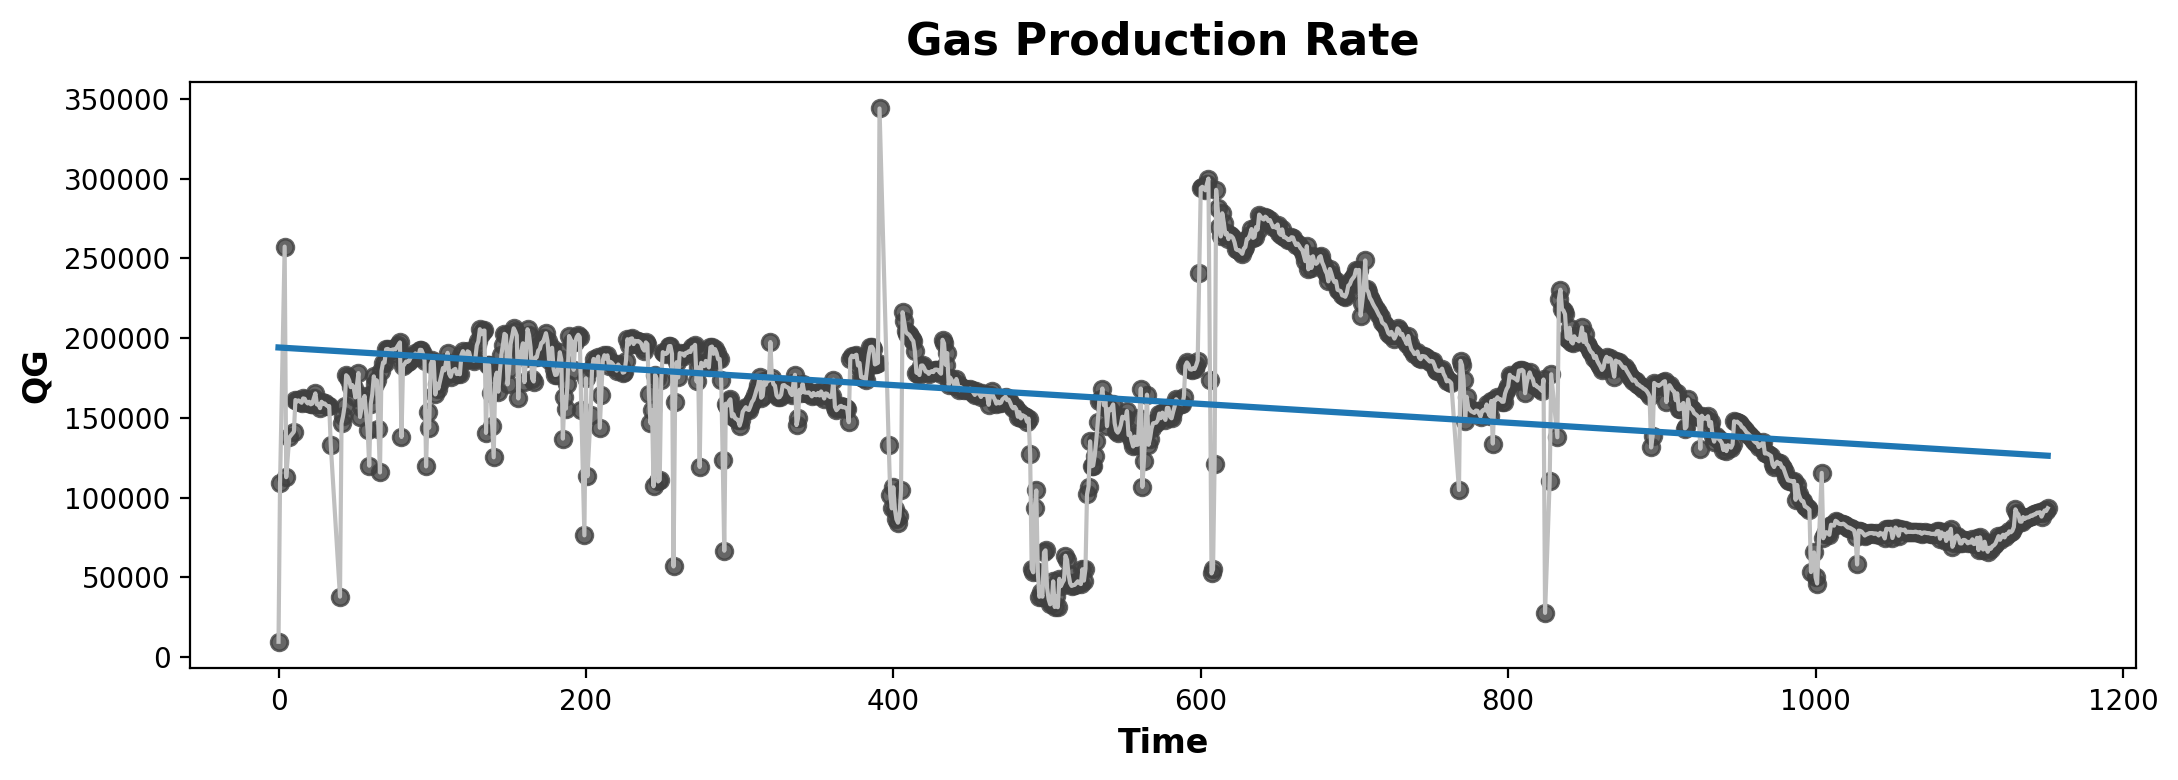

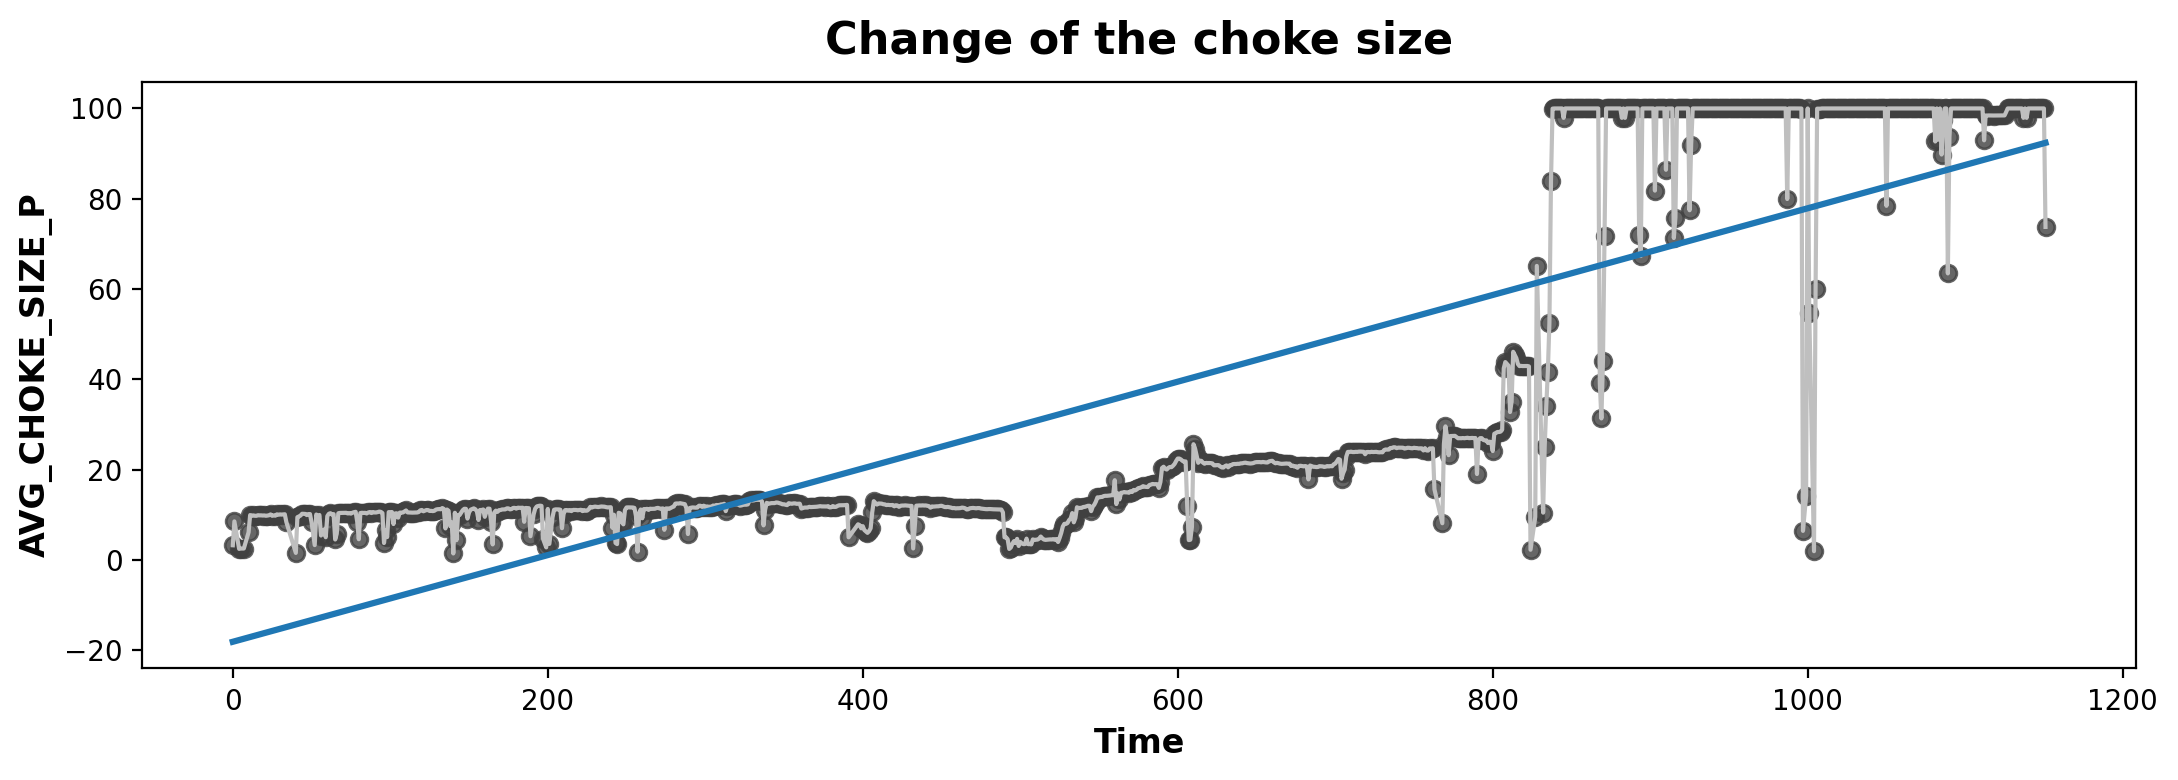

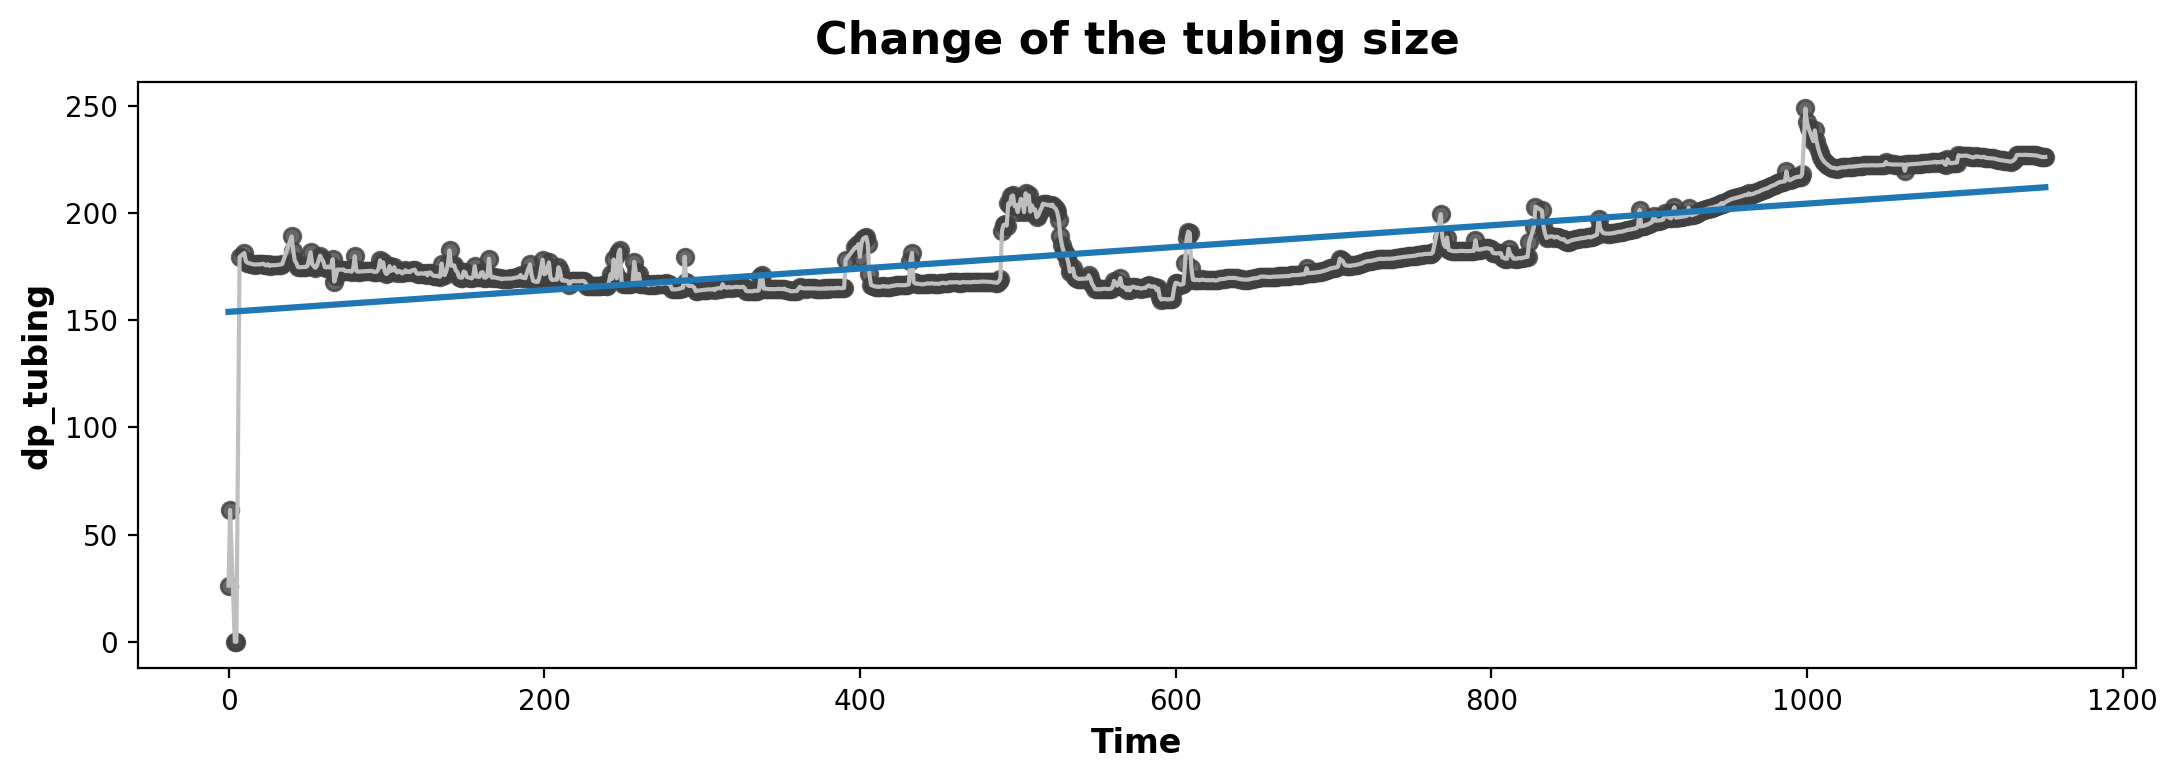

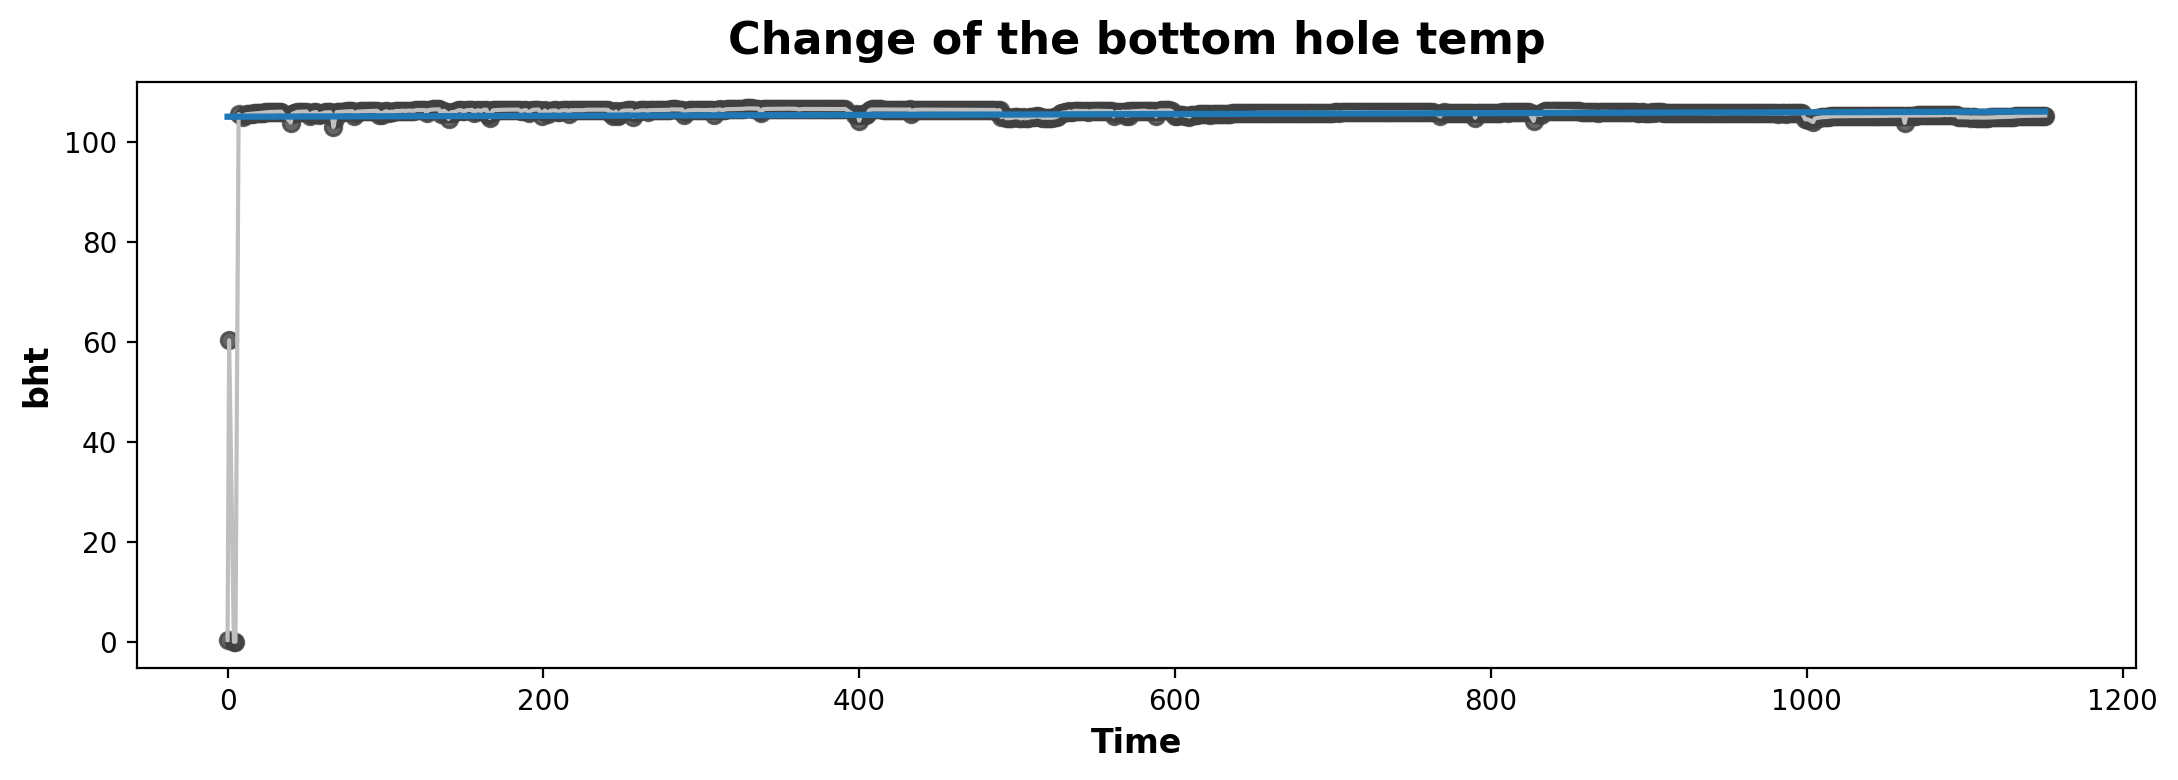

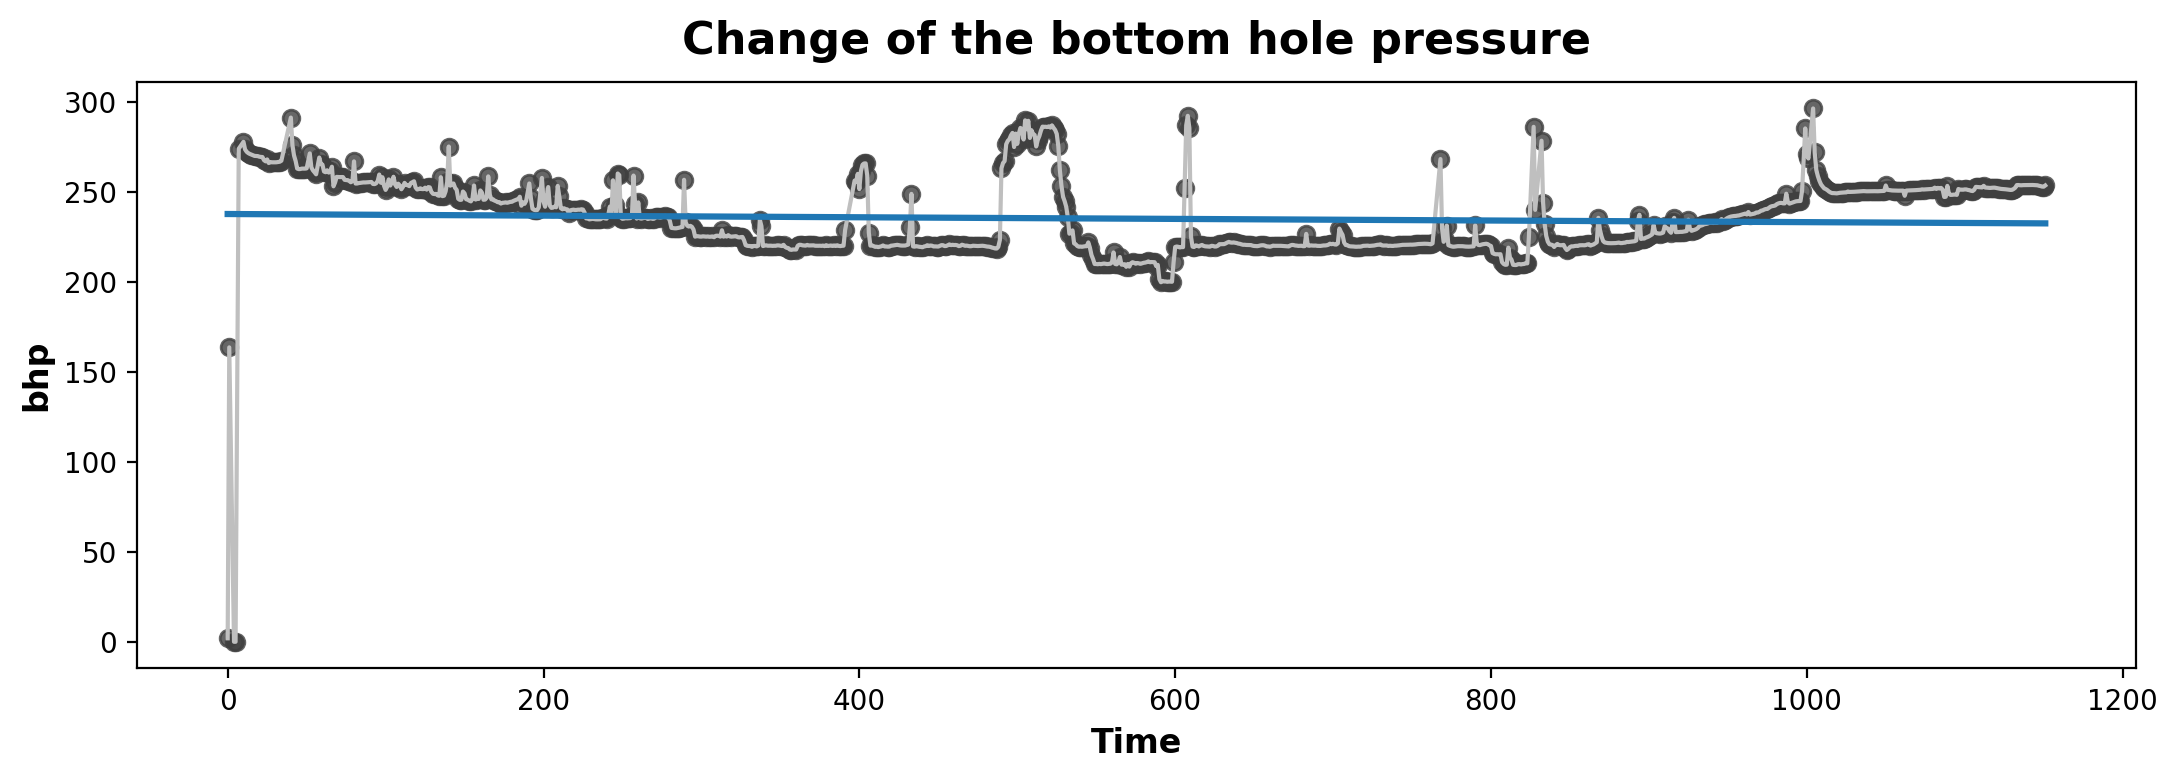

In [5]:
# Define a list of column names and their titles
plot_columns = [
    ('QG', 'Gas Production Rate'),
    ('AVG_CHOKE_SIZE_P', 'Change of the choke size'),
    ('dp_tubing', 'Change of the tubing size'),
    ('bht', 'Change of the bottom hole temp'),
    ('bhp', 'Change of the bottom hole pressure')
]

# Loop through each column and plot
for column, title in plot_columns:
    fig, ax = plt.subplots()
    ax.plot('Time', column, data=df, color='0.75')
    ax = sns.regplot(x='Time', y=column, data=df, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title(title)
    plt.show()

<h1 style=color:blue>plot the moving avrage to see the trend of the production</h1>

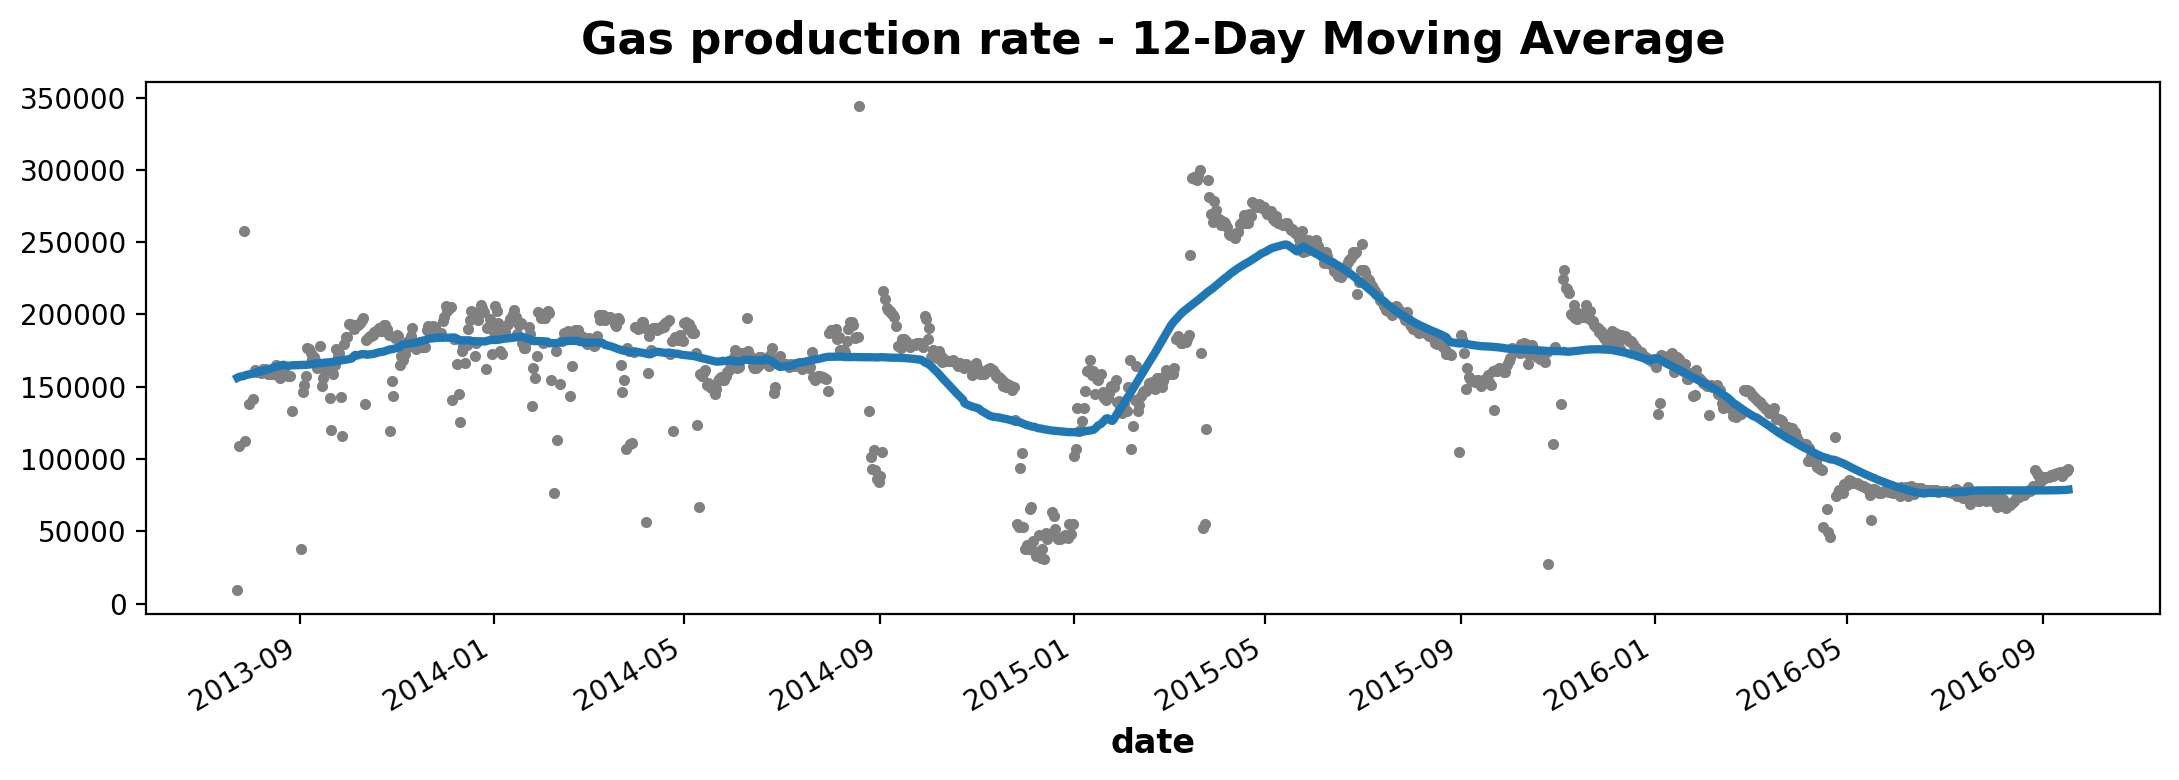

In [6]:
moving_average = df["QG"].rolling(
    window=120,       # 120-day window
    center=True,      # puts the average at the center of the window
    min_periods=30,  # choose about 1/3 the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df["QG"].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Gas production rate - 12-Day Moving Average", legend=False,
);

In [10]:
X = df.copy()
y = X.pop("QG")

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
# mi_scores[::3]  # show a few features with their MI scores
mi_scores

Time                2.004878
dp_tubing           1.483519
bhp                 1.118092
bht                 0.980004
AVG_CHOKE_SIZE_P    0.973503
Name: MI Scores, dtype: float64

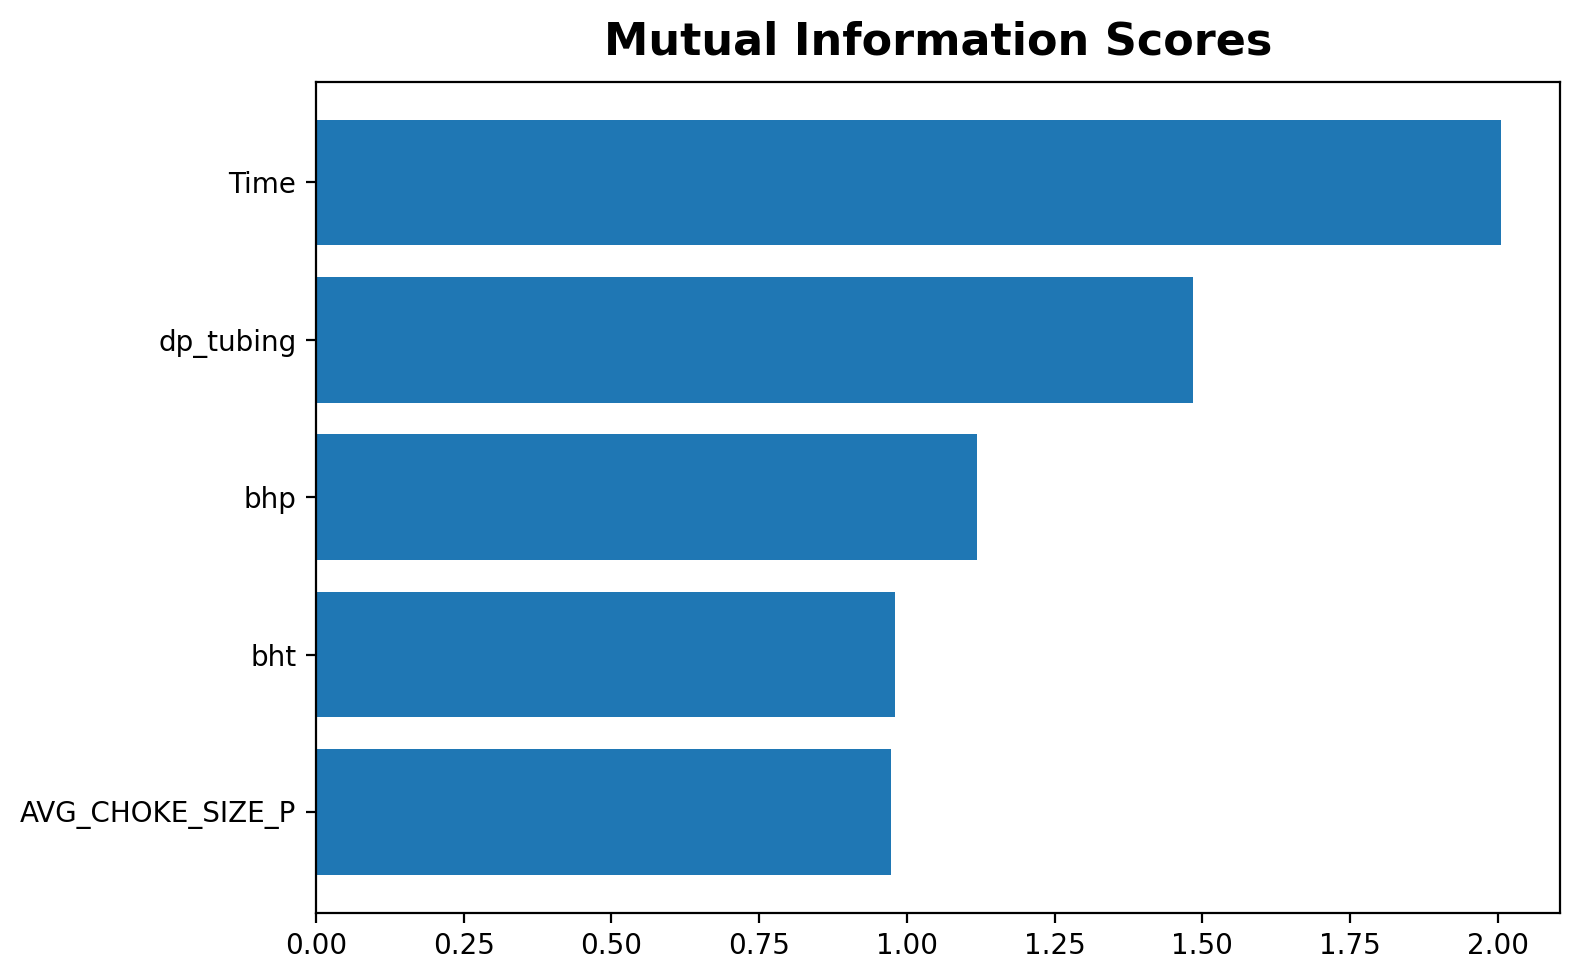

In [11]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

<h1 style="color : blue">writing some function that use to next steps</h1>

In [ ]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig